The two goals I have for this analysis are:
- Exercise with the library _panel_ and _hvplot_ to make a dynamic dashbord;
- Do the multivariate analysis to classify the room occupacy.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data2 = pd.read_csv('C:/Users/aleko/Downloads/occupancy_data/datatest.txt')
data2['date'] = data2.date.astype('datetime64[ns]')
data2 = data2.set_index('date')

data2.tail()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 10:38:59,24.290000,25.700000,808.0,1150.25,0.004829,1
2015-02-04 10:40:00,24.330000,25.736000,809.8,1129.20,0.004848,1
2015-02-04 10:40:59,24.330000,25.700000,817.0,1125.80,0.004841,1
2015-02-04 10:41:59,24.356667,25.700000,813.0,1123.00,0.004849,1
2015-02-04 10:43:00,24.408333,25.681667,798.0,1124.00,0.004860,1


In [4]:
from matplotlib.figure import Figure

%matplotlib inline

def mpl_plot(avg, highlight):
    fig = Figure()
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Temperature', window=30, sigma=20, view_fn=mpl_plot):
    avg = data2[variable].rolling(window=window).mean()
    residual = data2[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

In [5]:
import hvplot.pandas
import panel as pn

def hvplot(avg, highlight):
    return avg.hvplot(height=300) * highlight.hvplot.scatter(color='orange', padding=0.1)

text2 = "## Room Occupancy\nSelect the variable and the smoothing values"
hvp   = pn.interact(find_outliers, view_fn=hvplot)
pn.Column(pn.Row(pn.panel(text2, width=400), hvp[0]), hvp[1]).servable("Occupancy")

Column
    [0] Row
        [0] Markdown(str, width=400)
        [1] Column
            [0] IntSlider(end=90, name='window', start=-30, value=30, value_throttled=30)
            [1] IntSlider(end=60, name='sigma', start=-20, value=20, value_throttled=20)
    [1] Row
        [0] HoloViews(Overlay, name='interactive01464')

# Occupancy detection

### The real part of the analysis has the goal to find out the occypancy depending on different features.

### To achieve it I am going to use two different techniques, Machine Learning and Deep Learning.


In [4]:
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2, l1
from keras.metrics import BinaryAccuracy

In [5]:
datatest = pd.read_csv("C:/Users/aleko/Downloads/occupancy_data/datatest.txt")
datatest2 = pd.read_csv("C:/Users/aleko/Downloads/occupancy_data/datatest2.txt")
datatraining = pd.read_csv("C:/Users/aleko/Downloads/occupancy_data/datatraining.txt")

In [6]:
print(datatest.info())
datatest.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB
None


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [7]:
print(datatest2.info())
datatest2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           9752 non-null   object 
 1   Temperature    9752 non-null   float64
 2   Humidity       9752 non-null   float64
 3   Light          9752 non-null   float64
 4   CO2            9752 non-null   float64
 5   HumidityRatio  9752 non-null   float64
 6   Occupancy      9752 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 609.5+ KB
None


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [8]:
print(datatraining.info())
datatraining.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB
None


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


### For the ML part I am going to use a couple of classifiers like Support Vector Classification and KNeighborsClassifier. Both of them are appropriate because the datasets are not too big (<10k samples).


The first step is to convert the feature _date_ as _datetime_ in order to have the chance to manipulate the data and take a look at the progression of the occupancy in different time frames

In [9]:
datatest['date'] = pd.to_datetime(datatest['date'])
datatest2['date'] = pd.to_datetime(datatest2['date'])
datatraining['date'] = pd.to_datetime(datatraining['date'])
datatest.reset_index(drop=True, inplace=True)
datatest2.reset_index(drop=True, inplace=True)
datatraining.reset_index(drop=True, inplace=True)

In [10]:
datatest.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [11]:
datatest_copy = datatest.copy()
datatest2_copy = datatest2.copy()
datatraining_copy = datatraining.copy()

In [12]:
scaler = MinMaxScaler()
columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
scaler.fit(np.array(datatraining[columns])) #transformation in numpy arrays in order to feed the scaler
datatest[columns] = scaler.transform(np.array(datatest[columns]))
datatest2[columns] = scaler.transform(np.array(datatest2[columns]))
datatraining[columns] = scaler.transform(np.array(datatraining[columns]))

       Temperature     Humidity        Light          CO2  HumidityRatio
count  8143.000000  8143.000000  8143.000000  8143.000000    8143.000000
mean      0.387341     0.401676     0.077292     0.119942       0.312576
std       0.243281     0.247233     0.125947     0.194536       0.224186
min       0.000000     0.000000     0.000000     0.000000       0.000000
25%       0.167464     0.154431     0.000000     0.016246       0.106304
50%       0.332536     0.423623     0.000000     0.025220       0.296338
75%       0.571770     0.616307     0.165795     0.139925       0.441308
max       1.000000     1.000000     1.000000     1.000000       1.000000


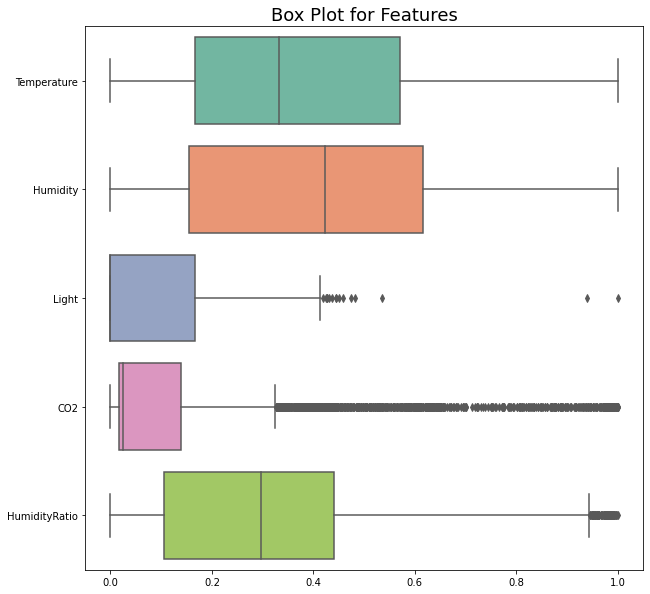

In [13]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.title('Box Plot for Features', fontdict={'fontsize':18})
ax = sns.boxplot(data=datatraining.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")
print(datatraining.drop(['date', 'Occupancy'],axis=1).describe())

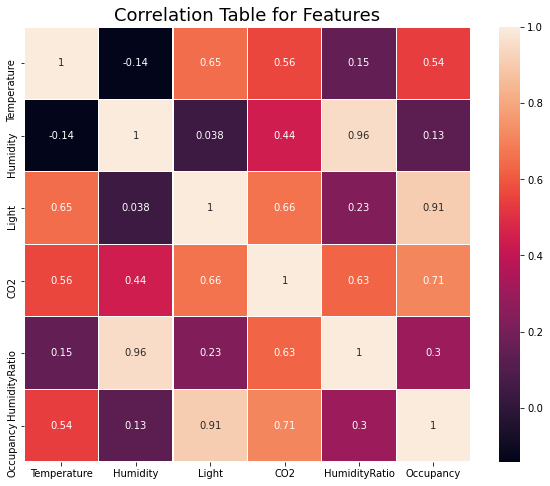

In [14]:
plt.figure(figsize=(10,8))
plt.title('Correlation Table for Features', fontdict={'fontsize':18})
ax = sns.heatmap(datatraining.corr(), annot=True, linewidths=.2)

In [15]:
hours_1 = [] #creating two different lists in order to see how the values are distributed between them
hours_0 = []
for date in datatraining[datatraining['Occupancy'] == 1]['date']:
    hours_1.append(date.hour)
for date in datatraining[datatraining['Occupancy'] == 0]['date']:
    hours_0.append(date.hour)

Text(0.5, 1.0, 'Density plots of different characters, per DC')

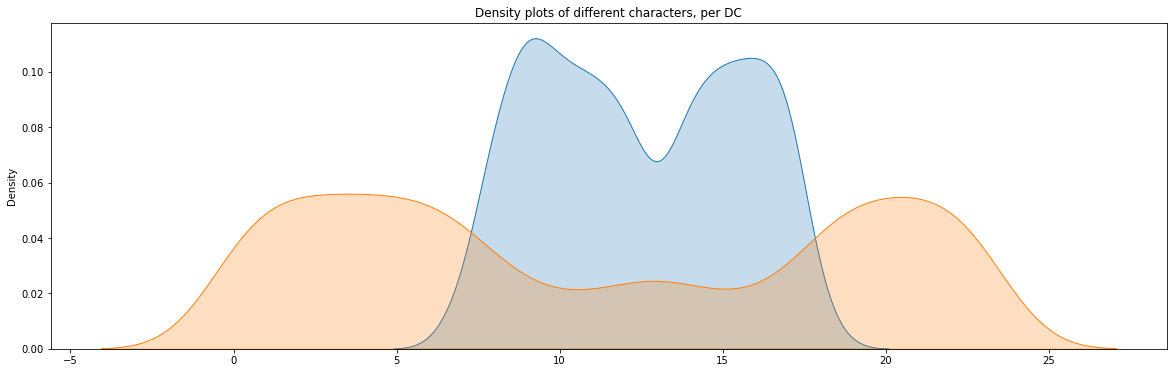

In [16]:
plt.figure(figsize=(20,6))
sns.kdeplot(data=hours_1, shade=True)
sns.kdeplot(data=hours_0, shade=True)
plt.title("Density plots of different characters, per DC")

In [35]:
days_1 = [] #creating two different lists in order to see how the values are distributed between them
days_0 = []
for date in datatest2[datatest2['Occupancy'] == 1]['date']:
    days_1.append(date.day)
for date in datatest2[datatest2['Occupancy'] == 0]['date']:
    days_0.append(date.day)

Text(0.5, 1.0, 'Density plots of different characters, per DC')

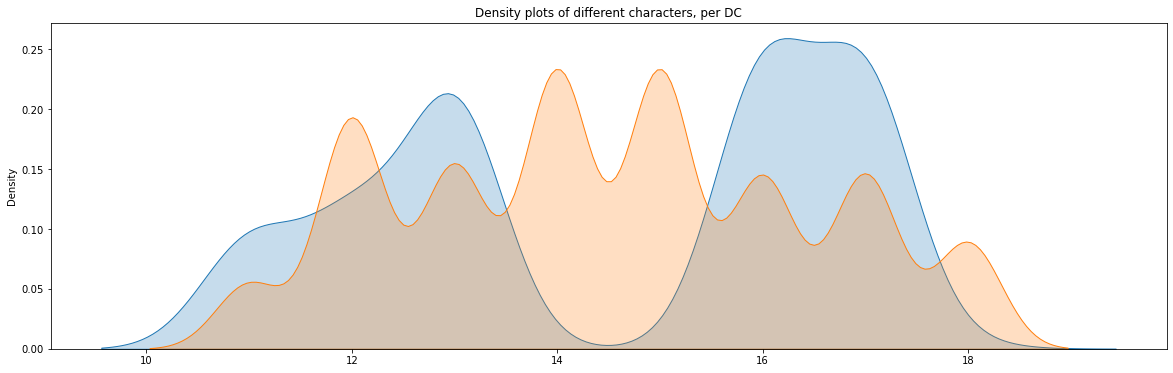

In [36]:
plt.figure(figsize=(20,6))
sns.kdeplot(data=days_1, shade=True)
sns.kdeplot(data=days_0, shade=True)
plt.title("Density plots of different characters, per DC")

In [37]:
np.median(days_0)

14.0

In [17]:
datatest2.date.describe()

<ipython-input-17-16bb8e0410b4>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                    9752
unique                   9752
top       2015-02-15 15:04:59
freq                        1
first     2015-02-11 14:48:00
last      2015-02-18 09:19:00
Name: date, dtype: object

In [18]:
datatest['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in datatest['date']]
datatest2['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in datatest2['date']]
datatraining['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in datatraining['date']]
datatraining.sample(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,period_of_day
4148,2015-02-07 14:58:59,0.741627,0.051179,0.052382,0.020733,0.068853,0,1
4090,2015-02-07 14:00:59,0.861244,0.016985,0.109129,0.014699,0.058614,0,1
4391,2015-02-07 19:01:59,0.287081,0.299475,0.000000,0.013771,0.197911,0,0
2564,2015-02-06 12:35:00,0.656699,0.165270,0.330782,0.252978,0.160600,1,1
652,2015-02-05 04:43:00,0.460925,0.324282,0.000000,0.021198,0.261912,0,0
3126,2015-02-06 21:56:59,0.251196,0.095877,0.000000,0.019341,0.015298,0,0
7435,2015-02-09 21:46:00,0.358852,0.748910,0.000000,0.144360,0.611839,0,0
1316,2015-02-05 15:47:00,0.830742,0.467203,0.309765,0.416061,0.500686,1,1
1471,2015-02-05 18:22:00,0.622010,0.306403,0.000000,0.211202,0.285996,0,0
4645,2015-02-07 23:16:00,0.155502,0.545312,0.000000,0.019031,0.373197,0,0


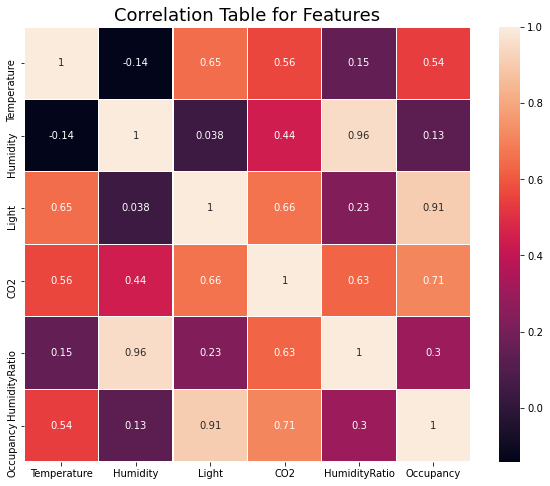

In [19]:
plt.figure(figsize=(10,8))
plt.title('Correlation Table for Features', fontdict={'fontsize':18})
ax = sns.heatmap(datatraining_copy.corr(), annot=True, linewidths=.2)

In [20]:
X_train = datatraining.drop(columns=['date', 'Occupancy'], axis=1)
y_train = datatraining['Occupancy']
X_validation = datatest.drop(columns=['date', 'Occupancy'], axis=1)
y_validation = datatest['Occupancy']
X_test = datatest2.drop(columns=['date', 'Occupancy'], axis=1)
y_test = datatest2['Occupancy']

In [21]:
# parameter-tuning for knn
n_neighbors_list = [7,15,45,135]
weights_list = ['uniform', 'distance']
metric_list = ['euclidean', 'manhattan']
accuracies = {}
for n in n_neighbors_list:
    for weight in weights_list:
        for metric in metric_list:
            knn_model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            knn_model.fit(X_train, y_train)
            accuracy = knn_model.score(X_validation, y_validation)
            accuracies[str(n)+"/"+weight+"/"+metric] = accuracy

In [22]:
plotdata = pd.DataFrame()
plotdata['Parameters'] = accuracies.keys()
plotdata['Accuracy'] = accuracies.values()
fig = px.line(plotdata, x="Parameters", y="Accuracy")
fig.update_layout(title={'text': "Accuracies for Different Hyper-Parameters",
                                                'x':0.7,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

In [23]:
max_abs_scaler = MaxAbsScaler()
columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
max_abs_scaler.fit(np.array(datatraining[columns])) #transformation in numpy arrays in order to feed the scaler
datatest_copy[columns] = max_abs_scaler.transform(np.array(datatest_copy[columns]))
datatest2_copy[columns] = max_abs_scaler.transform(np.array(datatest2_copy[columns]))
datatraining_copy[columns] = max_abs_scaler.transform(np.array(datatraining_copy[columns]))

In [24]:
X_train_copy = datatraining_copy.drop(columns=['date', 'Occupancy'], axis=1)
y_train_copy = datatraining_copy['Occupancy']
X_validation_copy = datatest_copy.drop(columns=['date', 'Occupancy'], axis=1)
y_validation_copy = datatest_copy['Occupancy']
X_test_copy = datatest2_copy.drop(columns=['date', 'Occupancy'], axis=1)
y_test_copy = datatest2_copy['Occupancy']

In [25]:
# parameter-tuning for knn
n_neighbors_list = [7,15,45,135]
weights_list = ['uniform', 'distance']
metric_list = ['euclidean', 'cosine']
accuracies_2 = {}
for n in n_neighbors_list:
    for weight in weights_list:
        for metric in metric_list:
            knn_model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            knn_model.fit(X_train_copy, y_train_copy)
            accuracy_2 = knn_model.score(X_validation_copy, y_validation_copy)
            accuracies_2[str(n)+"/"+weight+"/"+metric] = accuracy_2

In [26]:
plotdata_2 = pd.DataFrame()
plotdata_2['Parameters'] = accuracies_2.keys()
plotdata_2['Accuracy'] = accuracies_2.values()
fig = px.line(plotdata_2, x="Parameters", y="Accuracy")
fig.update_layout(title={'text': "Accuracies for Different Hyper-Parameters",
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

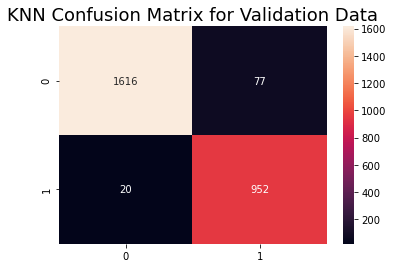

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=135)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_validation)
plt.title("KNN Confusion Matrix for Validation Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_validation, y_pred), annot=True, fmt="d")

In [28]:
knn_model.score(X_validation, y_validation)

0.9636022514071294

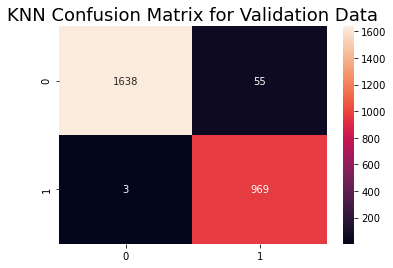

In [29]:
knn_model2 = KNeighborsClassifier(n_neighbors=135)
knn_model2.fit(X_train_copy, y_train_copy)
y_pred_copy = knn_model2.predict(X_validation_copy)
plt.title("KNN Confusion Matrix for Validation Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_validation_copy, y_pred_copy), annot=True, fmt="d")

In [30]:
knn_model2.score(X_validation_copy, y_validation_copy)

0.9782363977485928

In [31]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
print("Accuracy for SVM on validation data: {}%".format(round((svm_model.score(X_validation, y_validation)*100),2)))

Accuracy for SVM on validation data: 97.82%


In [32]:
svm_model2= SVC()
svm_model2.fit(X_train_copy, y_train_copy)
print("Accuracy for SVM on validation data: {}%".format(round((svm_model2.score(X_validation_copy, y_validation_copy)*100),2)))

Accuracy for SVM on validation data: 97.67%


### There's a first hint from the comparison of the scalers used that can be viewed in the SVC. In fact the results are pretty high and they tend to have a bigger score whit the _MaxAbsScaler_, but not for SVC. It could a signal of overfitting, especially because in the confusion matrix the false-positive are not balanced

In [33]:
# NN without regularization
model1 = Sequential()
model1.add(Dense(32, activation='relu', input_dim=6))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/50
255/255 [==============================] - 0s 2ms/step - loss: 0.3886 - accuracy: 0.9348 - val_loss: 0.1566 - val_accuracy: 0.9576
Epoch 2/50
255/255 [==============================] - 0s 947us/step - loss: 0.0993 - accuracy: 0.9735 - val_loss: 0.1029 - val_accuracy: 0.9614
Epoch 3/50
255/255 [==============================] - 0s 950us/step - loss: 0.0708 - accuracy: 0.9794 - val_loss: 0.0940 - val_accuracy: 0.9647
Epoch 4/50
255/255 [==============================] - 0s 960us/step - loss: 0.0627 - accuracy: 0.9832 - val_loss: 0.0915 - val_accuracy: 0.9719
Epoch 5/50
255/255 [==============================] - 0s 951us/step - loss: 0.0577 - accuracy: 0.9848 - val_loss: 0.0937 - val_accuracy: 0.9707
Epoch 6/50
255/255 [==============================] - 0s 935us/step - loss: 0.0550 - accuracy: 0.9848 - val_loss: 0.0954 - val_accuracy: 0.9677
Epoch 7/50
255/255 [==============================] - 0s 1ms/step - loss: 0.0525 - accuracy: 0.9850 - val_loss: 0.0839 - val_accuracy: 0.9

In [34]:
# NN with 0.2 dropout ratio before the hidden layer.
model2 = Sequential()
model2.add(Dense(32, activation='relu', input_dim=6))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/50
255/255 [==============================] - 0s 1ms/step - loss: 0.3530 - accuracy: 0.8654 - val_loss: 0.1671 - val_accuracy: 0.9437
Epoch 2/50
255/255 [==============================] - 0s 1ms/step - loss: 0.1118 - accuracy: 0.9670 - val_loss: 0.1030 - val_accuracy: 0.9614
Epoch 3/50
255/255 [==============================] - 0s 1ms/step - loss: 0.0776 - accuracy: 0.9763 - val_loss: 0.0939 - val_accuracy: 0.9674
Epoch 4/50
255/255 [==============================] - 0s 979us/step - loss: 0.0665 - accuracy: 0.9808 - val_loss: 0.0905 - val_accuracy: 0.9651
Epoch 5/50
255/255 [==============================] - 0s 1ms/step - loss: 0.0610 - accuracy: 0.9823 - val_loss: 0.0820 - val_accuracy: 0.9734
Epoch 6/50
255/255 [==============================] - 0s 1ms/step - loss: 0.0560 - accuracy: 0.9846 - val_loss: 0.0823 - val_accuracy: 0.9760
Epoch 7/50
255/255 [==============================] - 0s 1ms/step - loss: 0.0519 - accuracy: 0.9858 - val_loss: 0.0819 - val_accuracy: 0.9775
Epoc

In [35]:
# NN with L1(Lasso) regularization
model3 = Sequential()
model3.add(Dense(32, activation='relu', input_dim=6, kernel_regularizer=l1(l=0.01)))
model3.add(Dense(16, activation='relu', kernel_regularizer=l1(l=0.01)))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/50
255/255 [==============================] - 0s 1ms/step - loss: 1.1718 - accuracy: 0.7845 - val_loss: 0.6915 - val_accuracy: 0.6469
Epoch 2/50
255/255 [==============================] - 0s 1ms/step - loss: 0.4464 - accuracy: 0.8987 - val_loss: 0.3734 - val_accuracy: 0.9238
Epoch 3/50
255/255 [==============================] - 0s 1ms/step - loss: 0.3202 - accuracy: 0.9542 - val_loss: 0.3178 - val_accuracy: 0.9193
Epoch 4/50
255/255 [==============================] - 0s 1ms/step - loss: 0.2765 - accuracy: 0.9614 - val_loss: 0.2771 - val_accuracy: 0.9385
Epoch 5/50
255/255 [==============================] - 0s 1ms/step - loss: 0.2508 - accuracy: 0.9670 - val_loss: 0.2628 - val_accuracy: 0.9370
Epoch 6/50
255/255 [==============================] - 0s 1ms/step - loss: 0.2300 - accuracy: 0.9714 - val_loss: 0.2409 - val_accuracy: 0.9441
Epoch 7/50
255/255 [==============================] - 0s 1ms/step - loss: 0.2119 - accuracy: 0.9736 - val_loss: 0.2169 - val_accuracy: 0.9625
Epoch 

### Comparison between ML and DL

In [47]:
print("Accuracy for SVM on test data: {}%\n".format(round((svm_model.score(X_test, y_test)*100),2)))
print("Accuracy for SVM2 on test data: {}%\n".format(round((svm_model2.score(X_test_copy, y_test_copy)*100),2)))
print()
print()
print("Accuracy for Neural Network model on test data: {}%".format(round((model1.evaluate(X_test, y_test)[1]*100),2)))
print("Accuracy for Neural Network model on test data: {}%".format(round((model2.evaluate(X_test, y_test)[1]*100),2)))
print("Accuracy for Neural Network model on test data: {}%".format(round((model3.evaluate(X_test, y_test)[1]*100),2)))

Accuracy for SVM on test data: 98.38%

Accuracy for SVM2 on test data: 97.97%



305/305 [==============================] - 0s 581us/step - loss: 0.1349 - accuracy: 0.9475
Accuracy for Neural Network model on test data: 94.75%
305/305 [==============================] - 0s 581us/step - loss: 0.1230 - accuracy: 0.9759
Accuracy for Neural Network model on test data: 97.59%
305/305 [==============================] - 0s 640us/step - loss: 0.0961 - accuracy: 0.9918
Accuracy for Neural Network model on test data: 99.18%


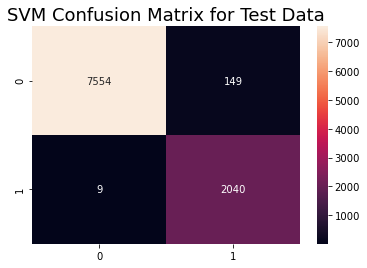

In [43]:
y_pred = svm_model.predict(X_test)
plt.title("SVM Confusion Matrix for Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

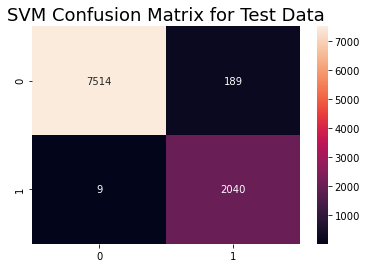

In [42]:
y_pred_copy = svm_model2.predict(X_test_copy)
plt.title("SVM Confusion Matrix for Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test_copy, y_pred_copy), annot=True, fmt="d")

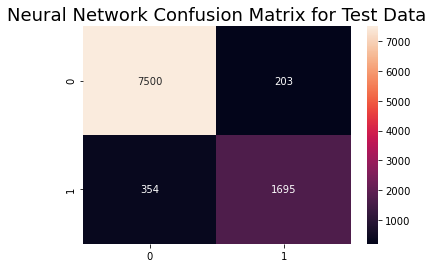

In [44]:
y_pred = model1.predict(X_test)
threshold = 0.6
y_pred = [1 if i >= threshold else 0 for i in y_pred]
plt.title("Neural Network Confusion Matrix for Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

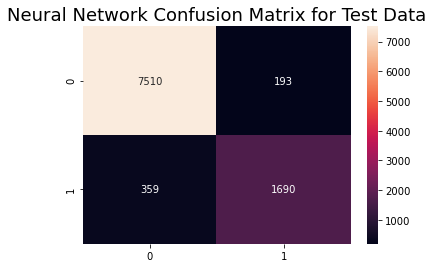

In [45]:
y_pred = model2.predict(X_test)
threshold = 0.6
y_pred = [1 if i >= threshold else 0 for i in y_pred]
plt.title("Neural Network Confusion Matrix for Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

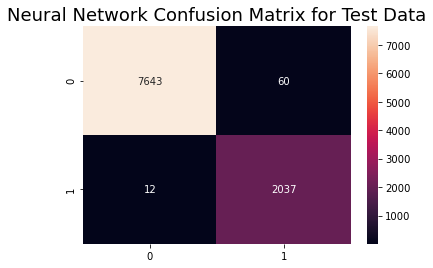

In [48]:
y_pred = model3.predict(X_test)
threshold = 0.6
y_pred = [1 if i >= threshold else 0 for i in y_pred]
plt.title("Neural Network Confusion Matrix for Test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

6. Conclusion
Both of the models did great job when predicting occupancy. Our accuracy is nearly 98%. So what do you think, which method (ML or DL) is suitable for this dataset and problem?

Before answer that, look at the confusion matrix which are created when evaluating models with the test data. SVM model looks like biased toward occupied class. But we don't have that problem with neural network. So we can say that, we could use neural network for more stable and accurate results without significant errors.

### Try to take a look at the whole data in order to see if with a larger sample there'd possible to find other relationships between the _features_ and the _classification_

In [49]:
data_all = pd.concat([datatest, datatest2, datatraining])
len(data_all)

20560

Text(0.5, 1.0, 'Density plots for occupancy during the whole dataset')

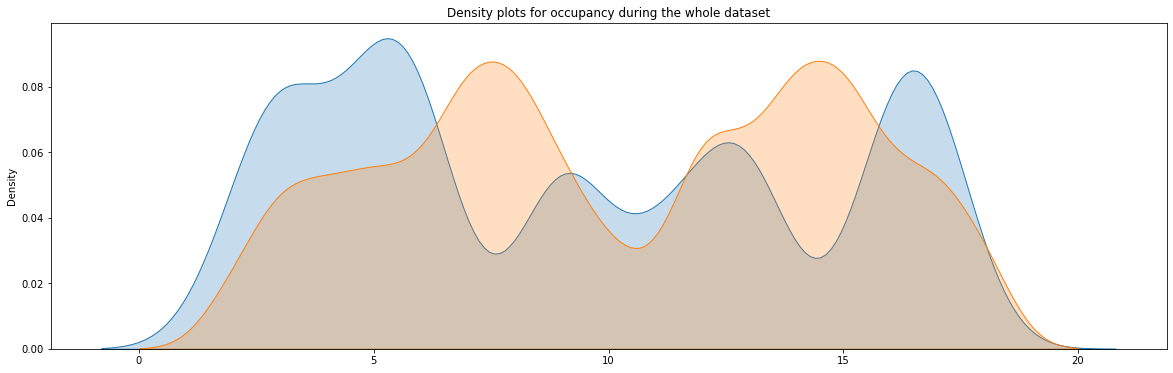

In [51]:
days_1_all = [] #creating two different lists in order to see how the values are distributed between them
days_0_all = []
for date in data_all[data_all['Occupancy'] == 1]['date']:
    days_1_all.append(date.day)
for date in data_all[data_all['Occupancy'] == 0]['date']:
    days_0_all.append(date.day)
    
plt.figure(figsize=(20,6))
sns.kdeplot(data=days_1_all, shade=True)
sns.kdeplot(data=days_0_all, shade=True)
plt.title("Density plots for occupancy during the whole dataset")

In [52]:
datatest.date.describe()

<ipython-input-52-108cd2a71630>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                    2665
unique                   2665
top       2015-02-03 14:45:59
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: date, dtype: object

In [53]:
datatest2.date.describe()

<ipython-input-53-16bb8e0410b4>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                    9752
unique                   9752
top       2015-02-15 15:04:59
freq                        1
first     2015-02-11 14:48:00
last      2015-02-18 09:19:00
Name: date, dtype: object

In [54]:
datatraining.date.describe()

<ipython-input-54-fd9453f6cd06>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                    8143
unique                   8143
top       2015-02-07 20:26:59
freq                        1
first     2015-02-04 17:51:00
last      2015-02-10 09:33:00
Name: date, dtype: object

The data available doesn't allowed to take even a small idea if there some type of seasonability due to difference between weekdays and weekends. The 3 parts of the dataset aren't continuos one to the other and because of that concatenating the 3 parts doesn't give any additional information. In particular, the step on the 4th of the month isn't as severe as the one between the 10th and the 11th were there's basically a whole day missing. The graph still gives an idea that probably would be interesting to analyze the effect of the _weekend_ in order to have some useful additional information. 